# GTSF phase: biomass prediction

In this notebook, we are forecasting the weights by finding the closest blender model

### Look at the volumes created with blender

Load blender data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
with open("/root/thomas/blender/volumes_all.json", "r") as f:
    data = json.load(f)

Some plot

In [3]:
# plt.scatter(np.array(data["dimensions"])[:, 1], data["volume"])
# plt.ylabel("Volume (cm^3)")
# plt.xlabel("Length (mm)")
# plt.show()

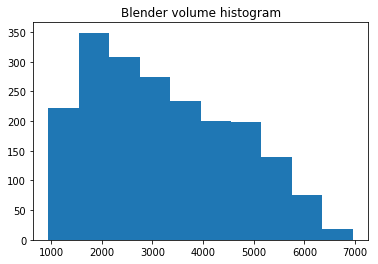

In [4]:
plt.hist(data["volume"])
plt.title("Blender volume histogram")
plt.show()

Calculate pairwise distances from blender data

In [5]:
mapping = data["mapping"]
reverse_mapping = data["reverse_mapping"]

In [58]:
mapping

{'ADIPOSE_FIN': 5,
 'ANAL_FIN': 1,
 'DORSAL_FIN': 4,
 'EYE': 7,
 'PECTORAL_FIN': 0,
 'PELVIC_FIN': 6,
 'TAIL_NOTCH': 3,
 'UPPER_LIP': 2}

In [6]:
number_of_parts = max(list(mapping.values()))+1

In [7]:
dataset = {"volume":[]}
dataset_np = []
kfactors = []
for (coord, vol) in zip(data["coordinates"], data["volume"]):
    row = []
    for k in range(number_of_parts):
        v = coord[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = coord[reverse_mapping[str(k0)]]
            dist = np.sqrt((v[2]-v0[2])**2 + (v[1]-v0[1])**2)
            cname = "{}-{}".format(k, k0)
            row.append(dist)
            if cname not in dataset:
                dataset[cname] = []
            dataset[cname].append(dist)
    dataset_np.append(row)
    dataset["volume"].append(vol)

Create panda dataframe

In [8]:
df = pd.DataFrame(data=dataset)
df.head()

,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-2,1-3,1-4,...,3-5,3-6,3-7,4-5,4-6,4-7,5-6,5-7,6-7,volume
0,210.696164,85.762188,351.122235,104.673940,231.240474,155.443793,63.171571,295.196907,143.112748,148.643877,...,127.674645,200.138776,406.633746,145.162289,111.082569,142.472777,98.626081,282.727410,215.735159,947.469760
1,210.705475,85.950449,351.189914,106.363262,231.700702,155.521437,63.695112,295.296565,143.388259,150.101572,...,127.906569,200.487039,406.635617,145.225464,113.602803,142.876388,100.537654,282.800882,216.130357,985.368078
2,210.715214,86.145627,351.260100,108.090461,232.177672,155.602191,64.234692,295.400216,143.673877,151.602006,...,128.147268,200.848032,406.637590,145.291195,116.164059,143.294418,102.485876,282.877081,216.540482,1023.265208
3,210.725380,86.347718,351.332793,109.853734,232.671261,155.686036,64.789919,295.507900,143.969542,153.143925,...,128.396706,201.221700,406.639681,145.359474,118.763663,143.726743,104.468680,282.956003,216.965448,1061.176026
4,210.735966,86.556661,351.407960,111.651385,233.181363,155.772966,65.360400,295.619591,144.275171,154.726089,...,128.654813,201.607946,406.641859,145.430288,121.399167,144.173240,106.484148,283.037640,217.405168,1099.083157


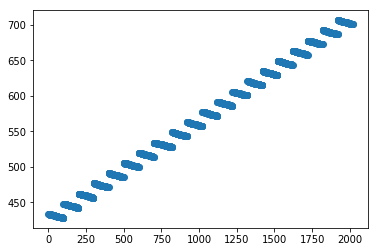

In [9]:
plt.plot(df["2-3"], "o")

## Look at the gtsf data

Loading the gtsf data points and creating the pairwise distances

In [10]:
import json
import os

In [11]:
jsonfiles = ["/root/data/gtsf_phase_I/2019-02-26/2019-02-26_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-02-27/2019-02-27_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-01/2019-03-01_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-04/2019-03-04_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-05/2019-03-05_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-06/2019-03-06_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-11/2019-03-11_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-13/2019-03-13_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-14/2019-03-14_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-18/2019-03-18_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-19/2019-03-19_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-21/2019-03-21_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-25/2019-03-25_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-27/2019-03-27_cogito_annotations.json"]

In [12]:
annotations = []
for jsonpath in jsonfiles:
    with open(jsonpath, "r") as f:
        jfile = json.load(f)
        annotations += jfile
print("Number of annotations: {}".format(len(annotations)))

Number of annotations: 1091


Add the local path for ease and rename the body parts

In [13]:
for ann in annotations:
    local_path = os.path.join("/root/data/gtsf_phase_I/", 
                  "/".join(ann["Labeled Data"].split("/")[7:]))
    ann["local_path"] = local_path
    if not os.path.isfile(local_path):
        print("missing image!!")
    for body_part in ann["Label"].keys():
        new_body_part = "_".join(body_part.replace(":", "").split()).upper()
        ann["Label"][new_body_part] = ann["Label"].pop(body_part)

### Find ground truth weight

In [14]:
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import Table, select, func, and_, insert, delete, update, or_

from tqdm import tqdm

In [15]:
sql_credentials = json.load(open("/root/thomas/sql_research_credentials.json"))

sql_engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                                         sql_credentials["host"], sql_credentials["port"],
                                         sql_credentials["database"]))

metadata = MetaData()
gtsf = Table('gtsf_data_collections', metadata, autoload=True, autoload_with=sql_engine)

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Get all the timestamps

In [16]:
timestamps = []
for ann in annotations:
    timestamp = ann["local_path"].split("/")[-3]
    ann["timestamp"] = timestamp
    timestamps.append(ann["timestamp"])

Query over all the timestamps

In [17]:
query = select([gtsf.c.ground_truth_metadata,
                gtsf.c.gtsf_fish_identifier]).select_from(gtsf).where(gtsf.c.gtsf_fish_identifier.in_(timestamps))
connection = sql_engine.connect()
q = connection.execute(query)
results = [(eval(r[0]), r[1]) for r in q]

Add the morphologic information to the annotations

In [18]:
for r in results:
    print(r[0])
    break

{'data': {'length': 591, 'width': 128, 'breath': 67, 'weight': 2363}, 'stereoFrames': '1', 'enclosureId': 1, 'time': 1551188021444, 'fishId': '190226010001'}


In [19]:
for ann in annotations:
    for r in results:
        if r[1] == ann["timestamp"]:
            ann["weight"] = r[0]["data"]["weight"]
            ann["breath"] = r[0]["data"]["breath"]
            ann["length"] = r[0]["data"]["length"]
            ann["width"] = r[0]["data"]["width"]
            ann["kfactor"] = 10**5*ann["weight"] / ann["length"]**3
            ann["species"] = r[0]["data"].get("species", "salmon")
            break

In [20]:
# [ann for ann in annotations if ann["kfactor"] < 0.6]

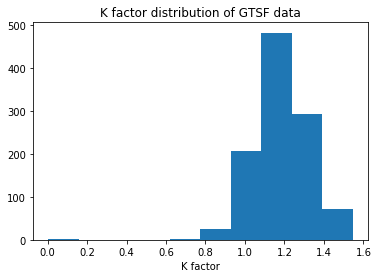

In [21]:
kfactor = np.array([ann["kfactor"] for ann in annotations if ann["species"] == "salmon"])
plt.hist(kfactor)
plt.title("K factor distribution of GTSF data")
plt.xlabel("K factor")
plt.show()

### 2D to 3D 

Move from 2d pixel coordinates to 3d world coordinates. First, need to create pairs

Creating pairs below

In [22]:
# create pairs per timestamp
pairs = {}
for ann in annotations:
    if ann["species"] != "salmon":
        continue
    if ann["kfactor"] < 0.3:
        continue
    timestamp = ann["timestamp"]
    side = os.path.basename(ann["local_path"]).split("_")[0]
    ann["side"] = side
    if timestamp not in pairs:
        pairs[timestamp] = {}
    pairs[timestamp][side] = ann

full_pairs = [k for (k, v)in pairs.items() if "left" in v and "right" in v]
print("Number of full pairs: {}".format(len(full_pairs)))

Number of full pairs: 535


In [23]:
pair1 = {"version": 1, "leftCrop": [{"xCrop": 1808, "yCrop": 125, "xFrame": 1931, "yFrame": 581, "keypointType": "UPPER_LIP"}, {"xCrop": 1686, "yCrop": 160, "xFrame": 1809, "yFrame": 616, "keypointType": "EYE"}, {"xCrop": 1034, "yCrop": 62, "xFrame": 1157, "yFrame": 518, "keypointType": "DORSAL_FIN"}, {"xCrop": 474, "yCrop": 318, "xFrame": 597, "yFrame": 774, "keypointType": "ADIPOSE_FIN"}, {"xCrop": 132, "yCrop": 582, "xFrame": 255, "yFrame": 1038, "keypointType": "TAIL_NOTCH"}, {"xCrop": 632, "yCrop": 530, "xFrame": 755, "yFrame": 986, "keypointType": "ANAL_FIN"}, {"xCrop": 1013, "yCrop": 463, "xFrame": 1136, "yFrame": 919, "keypointType": "PELVIC_FIN"}, {"xCrop": 1511, "yCrop": 309, "xFrame": 1634, "yFrame": 765, "keypointType": "PECTORAL_FIN"}], "rightCrop": [{"xCrop": 2266, "yCrop": 63, "xFrame": 2587, "yFrame": 717, "keypointType": "UPPER_LIP"}, {"xCrop": 2135, "yCrop": 145, "xFrame": 2456, "yFrame": 799, "keypointType": "EYE"}, {"xCrop": 1315, "yCrop": 95, "xFrame": 1636, "yFrame": 749, "keypointType": "DORSAL_FIN"}, {"xCrop": 651, "yCrop": 438, "xFrame": 972, "yFrame": 1092, "keypointType": "ADIPOSE_FIN"}, {"xCrop": 170, "yCrop": 816, "xFrame": 491, "yFrame": 1470, "keypointType": "TAIL_NOTCH"}, {"xCrop": 888, "yCrop": 670, "xFrame": 1209, "yFrame": 1324, "keypointType": "ANAL_FIN"}, {"xCrop": 1358, "yCrop": 585, "xFrame": 1679, "yFrame": 1239, "keypointType": "PELVIC_FIN"}, {"xCrop": 1957, "yCrop": 347, "xFrame": 2278, "yFrame": 1001, "keypointType": "PECTORAL_FIN"}]}
pair2 = {"version": 1, "leftCrop": [{"xCrop": 1148, "yCrop": 170, "xFrame": 2250, "yFrame": 1098, "keypointType": "UPPER_LIP"}, {"xCrop": 1082, "yCrop": 157, "xFrame": 2184, "yFrame": 1085, "keypointType": "EYE"}, {"xCrop": 649, "yCrop": 59, "xFrame": 1751, "yFrame": 987, "keypointType": "DORSAL_FIN"}, {"xCrop": 290, "yCrop": 162, "xFrame": 1392, "yFrame": 1090, "keypointType": "ADIPOSE_FIN"}, {"xCrop": 144, "yCrop": 244, "xFrame": 1246, "yFrame": 1172, "keypointType": "TAIL_NOTCH"}, {"xCrop": 379, "yCrop": 339, "xFrame": 1481, "yFrame": 1267, "keypointType": "ANAL_FIN"}, {"xCrop": 635, "yCrop": 345, "xFrame": 1737, "yFrame": 1273, "keypointType": "PELVIC_FIN"}, {"xCrop": 984, "yCrop": 239, "xFrame": 2086, "yFrame": 1167, "keypointType": "PECTORAL_FIN"}], "rightCrop": [{"xCrop": 1198, "yCrop": 174, "xFrame": 2340, "yFrame": 897, "keypointType": "UPPER_LIP"}, {"xCrop": 1126, "yCrop": 169, "xFrame": 2268, "yFrame": 892, "keypointType": "EYE"}, {"xCrop": 719, "yCrop": 71, "xFrame": 1861, "yFrame": 794, "keypointType": "DORSAL_FIN"}, {"xCrop": 313, "yCrop": 181, "xFrame": 1455, "yFrame": 904, "keypointType": "ADIPOSE_FIN"}, {"xCrop": 103, "yCrop": 264, "xFrame": 1245, "yFrame": 987, "keypointType": "TAIL_NOTCH"}, {"xCrop": 403, "yCrop": 343, "xFrame": 1545, "yFrame": 1066, "keypointType": "ANAL_FIN"}, {"xCrop": 658, "yCrop": 349, "xFrame": 1800, "yFrame": 1072, "keypointType": "PELVIC_FIN"}, {"xCrop": 996, "yCrop": 253, "xFrame": 2138, "yFrame": 976, "keypointType": "PECTORAL_FIN"}]}
pair3 = {"version": 1, "leftCrop": [{"xCrop": 1239, "yCrop": 115, "xFrame": 2493, "yFrame": 1342, "keypointType": "UPPER_LIP"}, {"xCrop": 1167, "yCrop": 124, "xFrame": 2421, "yFrame": 1351, "keypointType": "EYE"}, {"xCrop": 735, "yCrop": 77, "xFrame": 1989, "yFrame": 1304, "keypointType": "DORSAL_FIN"}, {"xCrop": 360, "yCrop": 222, "xFrame": 1614, "yFrame": 1449, "keypointType": "ADIPOSE_FIN"}, {"xCrop": 117, "yCrop": 356, "xFrame": 1371, "yFrame": 1583, "keypointType": "TAIL_NOTCH"}, {"xCrop": 455, "yCrop": 395, "xFrame": 1709, "yFrame": 1622, "keypointType": "ANAL_FIN"}, {"xCrop": 729, "yCrop": 368, "xFrame": 1983, "yFrame": 1595, "keypointType": "PELVIC_FIN"}, {"xCrop": 1071, "yCrop": 232, "xFrame": 2325, "yFrame": 1459, "keypointType": "PECTORAL_FIN"}], "rightCrop": [{"xCrop": 1180, "yCrop": 103, "xFrame": 2418, "yFrame": 1470, "keypointType": "UPPER_LIP"}, {"xCrop": 1121, "yCrop": 111, "xFrame": 2359, "yFrame": 1478, "keypointType": "EYE"}, {"xCrop": 753, "yCrop": 40, "xFrame": 1991, "yFrame": 1407, "keypointType": "DORSAL_FIN"}, {"xCrop": 349, "yCrop": 174, "xFrame": 1587, "yFrame": 1541, "keypointType": "ADIPOSE_FIN"}, {"xCrop": 160, "yCrop": 314, "xFrame": 1398, "yFrame": 1681, "keypointType": "TAIL_NOTCH"}, {"xCrop": 452, "yCrop": 313, "xFrame": 1690, "yFrame": 1680, "keypointType": "ANAL_FIN"}, {"xCrop": 701, "yCrop": 297, "xFrame": 1939, "yFrame": 1664, "keypointType": "PELVIC_FIN"}, {"xCrop": 1019, "yCrop": 205, "xFrame": 2257, "yFrame": 1572, "keypointType": "PECTORAL_FIN"}]}

In [24]:
pairs[1] = {}
ann_tmp = {}
label = {}
for kp in pair1["leftCrop"]:
    label[kp["keypointType"]] = [{"geometry": {"x": kp["xFrame"], "y": kp["yFrame"]}}]
ann_tmp["Label"] = label
pairs[1]["left"] = ann_tmp

ann_tmp = {}
label = {}
for kp in pair1["rightCrop"]:
    label[kp["keypointType"]] = [{"geometry": {"x": kp["xFrame"], "y": kp["yFrame"]}}]
ann_tmp["Label"] = label
pairs[1]["right"] = ann_tmp

pairs[2] = {}
ann_tmp = {}
label = {}
for kp in pair2["leftCrop"]:
    label[kp["keypointType"]] = [{"geometry": {"x": kp["xFrame"], "y": kp["yFrame"]}}]
ann_tmp["Label"] = label
pairs[2]["left"] = ann_tmp

ann_tmp = {}
label = {}
for kp in pair2["rightCrop"]:
    label[kp["keypointType"]] = [{"geometry": {"x": kp["xFrame"], "y": kp["yFrame"]}}]
ann_tmp["Label"] = label
pairs[2]["right"] = ann_tmp

pairs[3] = {}
ann_tmp = {}
label = {}
for kp in pair3["leftCrop"]:
    label[kp["keypointType"]] = [{"geometry": {"x": kp["xFrame"], "y": kp["yFrame"]}}]
ann_tmp["Label"] = label
pairs[3]["left"] = ann_tmp

ann_tmp = {}
label = {}
for kp in pair3["rightCrop"]:
    label[kp["keypointType"]] = [{"geometry": {"x": kp["xFrame"], "y": kp["yFrame"]}}]
ann_tmp["Label"] = label
pairs[3]["right"] = ann_tmp

In [25]:
pair2["leftCrop"]

[{'keypointType': 'UPPER_LIP',
  'xCrop': 1148,
  'xFrame': 2250,
  'yCrop': 170,
  'yFrame': 1098},
 {'keypointType': 'EYE',
  'xCrop': 1082,
  'xFrame': 2184,
  'yCrop': 157,
  'yFrame': 1085},
 {'keypointType': 'DORSAL_FIN',
  'xCrop': 649,
  'xFrame': 1751,
  'yCrop': 59,
  'yFrame': 987},
 {'keypointType': 'ADIPOSE_FIN',
  'xCrop': 290,
  'xFrame': 1392,
  'yCrop': 162,
  'yFrame': 1090},
 {'keypointType': 'TAIL_NOTCH',
  'xCrop': 144,
  'xFrame': 1246,
  'yCrop': 244,
  'yFrame': 1172},
 {'keypointType': 'ANAL_FIN',
  'xCrop': 379,
  'xFrame': 1481,
  'yCrop': 339,
  'yFrame': 1267},
 {'keypointType': 'PELVIC_FIN',
  'xCrop': 635,
  'xFrame': 1737,
  'yCrop': 345,
  'yFrame': 1273},
 {'keypointType': 'PECTORAL_FIN',
  'xCrop': 984,
  'xFrame': 2086,
  'yCrop': 239,
  'yFrame': 1167}]

In [26]:
pair2["rightCrop"]

[{'keypointType': 'UPPER_LIP',
  'xCrop': 1198,
  'xFrame': 2340,
  'yCrop': 174,
  'yFrame': 897},
 {'keypointType': 'EYE',
  'xCrop': 1126,
  'xFrame': 2268,
  'yCrop': 169,
  'yFrame': 892},
 {'keypointType': 'DORSAL_FIN',
  'xCrop': 719,
  'xFrame': 1861,
  'yCrop': 71,
  'yFrame': 794},
 {'keypointType': 'ADIPOSE_FIN',
  'xCrop': 313,
  'xFrame': 1455,
  'yCrop': 181,
  'yFrame': 904},
 {'keypointType': 'TAIL_NOTCH',
  'xCrop': 103,
  'xFrame': 1245,
  'yCrop': 264,
  'yFrame': 987},
 {'keypointType': 'ANAL_FIN',
  'xCrop': 403,
  'xFrame': 1545,
  'yCrop': 343,
  'yFrame': 1066},
 {'keypointType': 'PELVIC_FIN',
  'xCrop': 658,
  'xFrame': 1800,
  'yCrop': 349,
  'yFrame': 1072},
 {'keypointType': 'PECTORAL_FIN',
  'xCrop': 996,
  'xFrame': 2138,
  'yCrop': 253,
  'yFrame': 976}]

Some plotting

Match the keypoints and create world coordinates

In [27]:
from utils import depth_from_disp, convert_to_world_point, load_keypoints, euclidean_distance

In [28]:
rescale = False
new_shape = (512, 512)
height_ratio = new_shape[0] / 3000.0
width_ratio = new_shape[1] / 4096.0

In [37]:
world = {}
for ts in [1, 2, 3]:
    # load annotations
    left_ann = pairs[ts]["left"]
    # print(left_ann)
    right_ann = pairs[ts]["right"]
    # print(right_ann)
    
    left_keypoints = load_keypoints(left_ann, mapping)
    # print(left_keypoints)
    right_keypoints = load_keypoints(right_ann, mapping)
    # print(right_keypoints)
    
    if rescale:
        left_keypoints = left_keypoints * np.array([width_ratio, height_ratio])
        left_keypoints = np.array(left_keypoints, dtype=np.uint8)
        right_keypoints = right_keypoints * np.array([width_ratio, height_ratio])
        right_keypoints = np.array(right_keypoints, dtype=np.uint8)
        
    # calculate disparities
    disparities = left_keypoints[:, 1] - right_keypoints[:, 1]
    # print(disparities)
    # compute world key point
    world_keypoints = {}
    for (i, d) in enumerate(disparities):
        depth = depth_from_disp(d)
        world_coord = convert_to_world_point(left_keypoints[i, 0], left_keypoints[i, 1], depth)
        world_keypoints[list(mapping.keys())[i]] = world_coord
    world[ts] = world_keypoints

Plot world coordinates

In [34]:
# plt.scatter(left_keypoints[:, 0], left_keypoints[:, 1])
# for i in range(number_of_parts):
#     plt.text(left_keypoints[i, 0], left_keypoints[i, 1], list(mapping.keys())[i])
# plt.show()

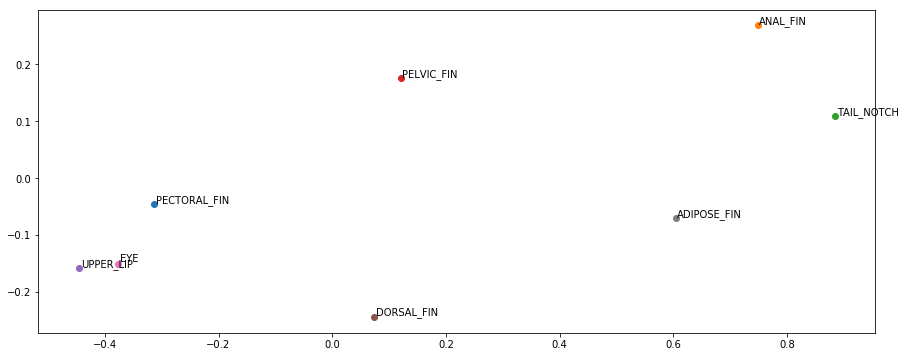

In [40]:
plt.figure(figsize=(15, 10))
for (k, v) in world[3].items():
    plt.scatter(v[0], v[2])
    plt.text(v[0]+0.003, v[2]+0.003, k)
    plt.axis("scaled")
plt.show()

### Forecasting

First, let's calculate the pairwise distances for the gtsf data. Second let's find the closest Blender model

In [43]:
predictions = []
predictions_average = []
ground_truth = []

for ts in world:
    # load keypoints
    world_keypoints = world[ts]
    # calculate distances
    measurements= []
    for k in range(number_of_parts):
        v = world_keypoints[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = world_keypoints[reverse_mapping[str(k0)]]
            dist = euclidean_distance(v, v0)*1000 # mm to m
            measurements.append(dist)
    print(measurements)
    # find closest blender volume
    # calculate l1 distance
    diff = np.nanmean(np.abs(np.array(df)[:, :-1] - measurements), axis=1)
    closest = np.argsort(diff)
    idx = 10
    closest5 = np.array(df)[closest[:idx], -1]
    print("closest volumes", closest5)
    print("standard dev:", np.std(closest5))
    print("estimated length", measurements[13])
    closest_length = np.array(list(df["2-3"].iloc()[closest[:idx]]))
    kfactor = 10**5*closest5 / closest_length**3
    print("closest length", closest_length)
    print("closest kfactor", kfactor)
    print("closest height", list(df["4-6"].iloc()[closest[:idx]]))
    print("#"*50)
    pred_volume = np.array(df)[closest[0], -1]
    predictions.append(pred_volume)
    predictions_average.append(np.mean(closest5))
    
    # ground truth
#     ground_truth_weight = [ann["weight"] for ann in annotations if ann["timestamp"] == ts][0]
#     ground_truth_kfactor = [ann["kfactor"] for ann in annotations if ann["timestamp"] == ts][0]
#     ground_truth.append([ground_truth_weight, ground_truth_kfactor])

[521.9143326180262, 1087.820514122552, 724.8009393807857, 307.36469836187223, 507.66108460100526, 410.7852636336849, 446.53374680438793, 1577.5878370345176, 213.86268440490497, 553.7339545328505, 147.7903422320371, 140.47267340681128, 948.6382367778969, 1788.5222645815531, 1071.191904924589, 1513.5396594475903, 1489.8156495788003, 643.5070662023346, 752.0564894248042, 307.44578052085376, 318.1978258583606, 1156.7554470904574, 457.5473790361628, 506.14713320402535, 488.5108593866949, 227.35220280398718, 899.0684461401174, 851.6161873561356]
closest volumes [5774.30532279 5905.52984149 6036.73736019 5665.29530726 6168.0693789
 5794.04482561 6299.23889759 5556.33979174 5922.82834396 6430.56991631]
standard dev: 264.8856473739223
estimated length 1788.5222645815531
closest length [706.48385603 705.88465611 705.28545702 706.48189755 704.68625868
 705.88269297 704.08706113 706.47993714 705.28348916 703.48786435]
closest kfactor [1.63754415 1.67902686 1.72070926 1.60664319 1.76263278 1.647343

In [51]:
tmp_meas= """2684.92980358  332.35755178 1184.08141775  495.63520638 1015.34894681
 1776.57965705  307.67928677 3010.22300125 2316.7343537  2364.15814777
 2021.60372757  969.82654924 2980.75134815 1386.37623863  741.1349069
 1276.90865534 2099.10758612   67.69223402  853.26597402  449.11099177
 1730.27620946 1321.52302624  585.2457656  1528.41323825  694.6478539
 1353.77570118 1221.00570886 2078.11299396"""
tmp_meas = [float(t) for t in tmp_meas.split()]

In [53]:
tmp_meas = """423.59659438 118.69470273 571.57517227 253.73100651 474.48223513
 273.11181083  79.59655751 501.75527985 238.34702309 280.47944047
 214.21327857 163.1917898  491.30301233 667.59069335 332.97026956
 569.06195017 345.40201862  76.70760669 362.94126826 114.93850252
 371.08882481 634.58451829 252.52398985 220.38174009 294.64349748
 306.71541616 532.27316335 342.06575775"""
tmp_meas = [float(t) for t in tmp_meas.split()]

In [57]:
diff = np.nanmean(np.abs(np.array(data["distances"]) - tmp_meas), axis=1)
idx = 10
closest5 = np.array(df)[closest[:idx], -1]
print("closest volumes", closest5)
print("standard dev:", np.std(closest5))
print("estimated length", measurements[13])

closest volumes [5774.30532279 5905.52984149 5665.29530726 6036.73736019 5794.04482561
 6168.0693789  5556.33979174 5922.82834396 6299.23889759 5682.70480974]
standard dev: 222.29132908841376
estimated length 1548.8853783873303


In [ ]:
predictions = np.array(predictions)
predictions_average = np.array(predictions_average)
ground_truth = np.array(ground_truth)
gt_weight = ground_truth[:, 0]
gt_kfactor = ground_truth[:, 1]

**OLD CODE**

Quick OLS. 

$\hat{\beta} = (X^{T}X)^{-1}X^{T}Y$

(just for Alok)

In [ ]:
# ground_truth = ground_truth[:, np.newaxis]
# ground_truth.shape
# A = np.linalg.inv(np.matmul(ground_truth.transpose(), ground_truth))
# B = np.matmul(ground_truth.transpose(), predictions)
# coeff = 1 / (A*B)
# print("Reg coeff: {}".format(coeff))
# plt.figure(figsize=(10, 10))
# plt.plot([0, 5000], [0, 5000], "--", c="r", linewidth=2)
# plt.scatter(ground_truth, predictions*coeff)
# #plt.scatter(ground_truth, predictions)
# plt.xlabel("Ground truth weight")
# plt.ylabel("Predicted weight")
# plt.axis("scaled")
# plt.show()

**Linear reg New code**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
predictions = predictions[:, np.newaxis]
reg = LinearRegression().fit(predictions, gt_weight)
print(reg.coef_, reg.intercept_)
print("R2 : {}".format(reg.score(predictions, gt_weight)))
predictions = np.squeeze(predictions)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 5000], [0, 5000], "--", c="r", linewidth=2)
plt.scatter(gt_weight, predictions*reg.coef_ + reg.intercept_, c=gt_kfactor)
#plt.scatter(ground_truth, predictions)
plt.xlabel("Ground truth weight")
plt.ylabel("Predicted weight")
plt.colorbar()
plt.clim([0.8, 1.6])
plt.axis("scaled")
plt.show()

In [ ]:
fitted_predictions = predictions*reg.coef_ + reg.intercept_
error = fitted_predictions-gt_weight
print("Average absolute error: {}".format(np.nanmean(np.abs(error))))
print("Average error: {}".format(np.nanmean(error)))
# error5 = predictions_average-ground_truth
#print("Average absolute error5: {}".format(np.nanmean(np.abs(error5))))
relative_error = ((fitted_predictions-gt_weight) / gt_weight)*100
print("Average relative error: {} %".format(np.nanmean(relative_error)))

In [ ]:
from scipy.stats.kde import gaussian_kde

In [ ]:
kde = gaussian_kde(error)
dist_space = np.linspace( min(error), max(error), 100 )
plt.hist(error, bins=20, density=True)
plt.plot( dist_space, kde(dist_space) )
plt.title("Error")
plt.show()

In [ ]:
kde = gaussian_kde(relative_error)
dist_space = np.linspace( min(relative_error), max(relative_error), 100 )
plt.hist(relative_error, bins=20, density=True)
plt.plot( dist_space, kde(dist_space) )
plt.title("Relative Error (%)")
plt.show()

**Percentile plot**

In [ ]:
values = np.arange(0, 101, 5)
percentiles = np.percentile(np.abs(relative_error), values)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(percentiles, values)
plt.yticks(np.arange(0,101,5))
plt.ylabel("Percentage")
plt.xlabel("Absolute relative error (%)")
plt.grid()
plt.show()

**KS test**

In [ ]:
from scipy.stats import kstest
from scipy.optimize import curve_fit
from scipy.stats import norm

In [ ]:
mean, std = norm.fit(fitted_predictions)
print("Mean: {}, Standard deviation: {}".format(mean, std))
plt.hist(fitted_predictions, bins=20, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()

In [ ]:
kstest(fitted_predictions, norm(loc=mean, scale=std).cdf)

**Cross validation**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# predictions = np.squeeze(predictions)
# all_errors = []
# for i in np.arange(0.1, 1.0, 0.1):
#     predictions = predictions[:, np.newaxis]
#     test_size = i
#     print(test_size)
#     X_train, X_test, y_train, y_test = train_test_split(predictions, ground_truth, test_size=test_size)
#     X_test= np.squeeze(X_test)
    
#     plt.scatter(X_train, y_train)
#     plt.scatter(X_test, y_test)
#     plt.axis("scaled")
#     plt.show()
    
#     reg = LinearRegression().fit(X_train, y_train)
#     print(reg.coef_, reg.intercept_)
#     print("R2 : {}".format(reg.score(X_train, y_train)))
#     predictions = np.squeeze(predictions)
    
    
#     fitted_X_test = X_test*reg.coef_ + reg.intercept_
#     error = fitted_X_test-y_test
#     print("Average absolute error: {}".format(np.nanmean(np.abs(error))))
#     print("Average error: {}".format(np.nanmean(error)))
#     relative_error = ((fitted_X_test-y_test) / y_test)*100
#     print("Average relative error: {} %".format(np.nanmean(relative_error)))
#     all_errors.append(np.nanmean(relative_error))
#     print("#"*50)
# plt.plot(np.arange(0.1, 1.0, 0.1)*100 , all_errors)
# plt.ylabel("Test set average relative error")
# plt.xlabel("Test set size (% of total pop)")
# plt.show()

In [ ]:
predictions = np.squeeze(predictions)
all_errors = []
all_relative_errors = []
for i in range(1000):
    predictions = predictions[:, np.newaxis]
    test_size = i
    X_train, X_test, y_train, y_test = train_test_split(predictions, gt_weight, test_size=0.2)
    X_test= np.squeeze(X_test)
    
    reg = LinearRegression().fit(X_train, y_train)
    # print(reg.coef_, reg.intercept_)
    # print("R2 : {}".format(reg.score(X_train, y_train)))
    predictions = np.squeeze(predictions)
    
    
    fitted_X_test = X_test*reg.coef_ + reg.intercept_
    error = fitted_X_test-y_test
    relative_error = ((fitted_X_test-y_test) / y_test)*100
    all_errors.append(np.nanmean(error))
    all_relative_errors.append(np.nanmean(relative_error))


In [ ]:
plt.hist(all_errors)
plt.xlabel("Average error distribution")
plt.show()
plt.hist(all_relative_errors)
plt.xlabel("Average relative error distribution")
plt.show()